In [1]:
import SCOTCH
import pandas as pd 
import anndata as ad
import scanpy as sc
import torch 

import matplotlib.pyplot as plt

# Running SCOTCH on Simulated Data 

This notebook is an example of utilizing SCOTCH to factor an example matrix, with a generated block structure. The matrix is found in the text "test/A.txt". The matrix contains 500 rows and 1000 columns. The matrix naturally can be factorized into 3 row clusters and 9 column clusters. In the code block below, we load the A matrix into a pandas dataframe and visualize the heatmap. 

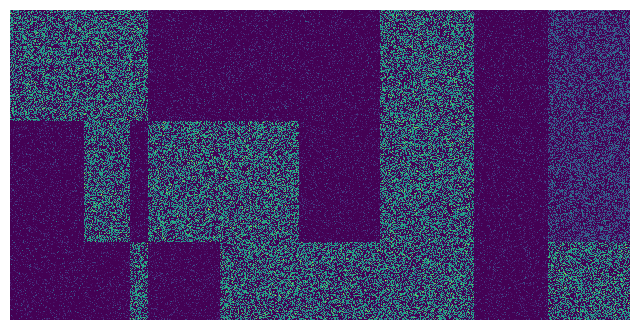

In [2]:
A = pd.read_csv("test/A.txt", sep = '\t', header=None)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.imshow(A, cmap='viridis', interpolation='nearest')
ax.set_axis_off()

SCOTCH interfaces with anndata structure to perform its . In the next code block we convert A into an anndata object and initialize a scotch object. For the first factor example, we are using $k1=3$, and $k2 = 9$. These are the expected number of row and column clusters respectively. $max\_l\_u$ and $max\_l\_v$ corresponds to the orthogonal regularization parameter. In general, it is recommended to use regularization with scotch. We are running it without regularization in the context to demonstrate the poor clustering performance and to estimate the error associated NMTF without regularization. 

An explanation of the remaining parameters is below: 
* var_lambda: SCOTCH allows for a ramping of the regularization parameters using a sigmoid scheduler. In general this is not need to determine good clusters and embeddings. By setting this to False, the max_l_u and max_l_v values are used for all interactions of the update. 
     
* device: SCOTCH updates are GPU enabled for reasonably sized feature matrices. If using a GPU this should point to the name of the GPU device. 
     
* init_style: SCOTCH supports multiple different NM(T)F initializations. Here we are initializing all elements of $U$, $V$, and $S$. Other supported values of this parameter are "nnsvd" for non-negative SVD initialization.
       
* draw_intermediate_graph: This parameter allows for visualization of the factors and estimates during the SCOTCH update. Each full update of $U$, $S$, and $V$ are captured into a frame and stitched together and can be stitched into a GIF. Including this parameter does slow down the update especially for large expression matrices. 

After initializing SCOTCH, we add the data from adata object to scotch for factorization. 
    

In [3]:
adata = ad.AnnData(A)
scotch = SCOTCH.SCOTCH(k1 = 3, k2 = 9, max_l_u = 0.0, max_l_v = 0.0, term_tol = 1e-10, var_lambda= False, device = "cpu", init_style="random", draw_intermediate_graph=True)
scotch.add_data_from_adata(adata)

/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


This block runs SCOTCH. If the verbose SCOTCH input parameter The following information is printed for each iteration: 

* Iter - the current interation that is being run. 
* Iter time - The time that it took to complete the iteration. Iteration 1 generally takes longer than all other iters due to some initialization at the beginning of SCOTCH. 
* Total time - the current run time. 
* Objective - An estimate of the objective. 
* Relative Delta Objective - The change relative in the objective from the previous iteration. When this value is less that term_tol, and greater than zero the algorithm with stop. 
* Reconstruction error - This is the component of the objective related to $|| X - USV^T ||_F^2$. This value is comparable across different random initialization or with different regularization parameters. 

In [4]:
scotch.fit()

Initializing NMTF factors
Beginning NMTF
Iter: 1	Iter Time: 0.508	Total Time: 0.508	Objective: 8.158e+06	Relative Delta Objective: 1.910e-01	Reconstruction Error: 8.158e+06
Iter: 2	Iter Time: 0.286	Total Time: 0.793	Objective: 7.971e+06	Relative Delta Objective: 2.294e-02	Reconstruction Error: 7.971e+06
Iter: 3	Iter Time: 0.413	Total Time: 1.206	Objective: 7.573e+06	Relative Delta Objective: 4.989e-02	Reconstruction Error: 7.573e+06
Iter: 4	Iter Time: 0.298	Total Time: 1.505	Objective: 7.262e+06	Relative Delta Objective: 4.104e-02	Reconstruction Error: 7.262e+06
Iter: 5	Iter Time: 0.251	Total Time: 1.756	Objective: 7.028e+06	Relative Delta Objective: 3.219e-02	Reconstruction Error: 7.028e+06
Iter: 6	Iter Time: 0.402	Total Time: 2.158	Objective: 6.895e+06	Relative Delta Objective: 1.894e-02	Reconstruction Error: 6.895e+06
Iter: 7	Iter Time: 0.231	Total Time: 2.389	Objective: 6.840e+06	Relative Delta Objective: 8.043e-03	Reconstruction Error: 6.840e+06
Iter: 8	Iter Time: 0.281	Total Time

If the draw_intermediate_graph is set to true, you can write a gif using the following function after initialization. It is saved to the SCOTCH output directory, under the following file name. 

In [5]:
scotch.write_gif('NMTF_no_reg.gif')


writing gif to ./NMTF_no_reg.gif


![NMTF without ortho-regularization](NMTF_no_reg.gif)

In this context, without regularization, the SCOTCH fit is roughly equivalent to the NMF fit. First the three U factors, are related to a single V factor (this is indicated by the three bright values of the S matrix). Each of the three main factors of V represent the mean profile of each of the correspond cell blocks. The remaining factors of V (3-8) are contributing little to the estimation scheme). Below we repeat the SCOTCH runs with regularization. The value of lambda can range from $[0, 1]$ but in practice we find that the values between $0.05$ and $0.20$ produce orthogonal vector representations of U and V without drastically increasing the reconstructions error.  

In [6]:
scotch = SCOTCH.SCOTCH(k1 = 3, k2 = 9, max_l_u = 0.15, max_l_v = 0.15, term_tol = 1e-10, var_lambda= False, device = "cpu", init_style="random", max_iter=200)
scotch.draw_intermediate_graph = True
scotch.add_data_from_adata(adata)
scotch.fit()

Initializing NMTF factors
Beginning NMTF
Iter: 1	Iter Time: 0.603	Total Time: 0.603	Objective: 8.150e+06	Relative Delta Objective: 1.917e-01	Reconstruction Error: 8.150e+06
Iter: 2	Iter Time: 0.335	Total Time: 0.938	Objective: 7.943e+06	Relative Delta Objective: 2.539e-02	Reconstruction Error: 7.943e+06
Iter: 3	Iter Time: 0.342	Total Time: 1.280	Objective: 7.542e+06	Relative Delta Objective: 5.049e-02	Reconstruction Error: 7.542e+06
Iter: 4	Iter Time: 0.313	Total Time: 1.593	Objective: 7.279e+06	Relative Delta Objective: 3.486e-02	Reconstruction Error: 7.279e+06
Iter: 5	Iter Time: 0.441	Total Time: 2.034	Objective: 7.054e+06	Relative Delta Objective: 3.094e-02	Reconstruction Error: 7.054e+06
Iter: 6	Iter Time: 0.328	Total Time: 2.362	Objective: 6.918e+06	Relative Delta Objective: 1.935e-02	Reconstruction Error: 6.918e+06
Iter: 7	Iter Time: 0.250	Total Time: 2.612	Objective: 6.892e+06	Relative Delta Objective: 3.653e-03	Reconstruction Error: 6.892e+06
Iter: 8	Iter Time: 0.373	Total Time

In [7]:
scotch.write_gif('NMTF_lU_lV_0.15.gif')

writing gif to ./NMTF_lU_lV_0.15.gif


![NMTF with Reg 0.15](NMTF_lU_lV_0.15.gif)

This factorization produces a much richer representation in S which indicate the relationship between column clusters and row clusters. The function below plots the factors in a manor where they are sorted by the U and V with maximum contributions. In the sorted representation below we can see that most factors of U and V are orthogonal. Notably, some of the factors in V, e.g. 3, 4, and 5, larely reflect a similar trend in the matrix. Specifically, they capture columns which are representation in all clusters.

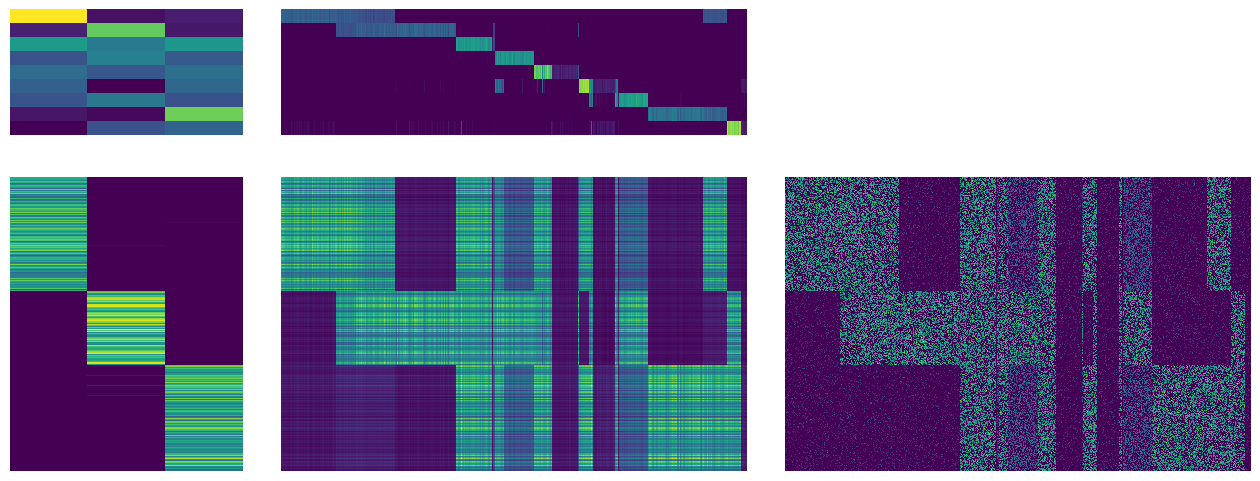

In [8]:
fig = scotch.visualize_factors_sorted()
display(fig)

The orthogonal representation naturally lends itself to assigning these row and column features to clusters. For each row of U and V (note the representation above shows $V^T$) we assign them to the cluster based on the $argmax(U[i, :])$ and $argmax(V[i, :])$. The clustering is implemented in the assign_cluster function below. After assigning clusters, the SCOTCH information can be directly added back to the adata object using he addScotchEmbeddingToAnnData() function. 

In [9]:
scotch.assign_cluster()

In [10]:
scotch.add_scotch_embeddings_to_adata(adata, 'NMTF_lU_lV_0.15')

AnnData object with n_obs × n_vars = 500 × 1000
    obs: 'NMTF_lU_lV_0.15_cell_clusters'
    var: 'NMTF_lU_lV_0.15_gene_clusters'
    uns: 'NMTF_lU_lV_0.15_S_matrix', 'NMTF_lU_lV_0.15_reconstruction_error', 'NMTF_lU_lV_0.15_error'
    obsm: 'NMTF_lU_lV_0.15_cell_embedding', 'NMTF_lU_lV_0.15_P_embedding'
    varm: 'NMTF_lU_lV_0.15_gene_embedding', 'NMTF_lU_lV_0.15_Q_embedding'

We can visualize the different U and V components using UMAP below. The first UMAP is generated using PCA.  The second and third UMAP are generated using the SCOTCH embeddings. First using $U$, and second using $U*S = P$. The $U$ matrix's orthogonality may lead to poor representations in the UMAP space due to the instability in the knn graph. Generally this can be improved by increasing the number of neighbors. The $P$ embedding generally produces better representation in the UMAP space because it is less effected by the orthogonality constraint. The 4th UMAP demonstrates the relationships captured in the column space. 

/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


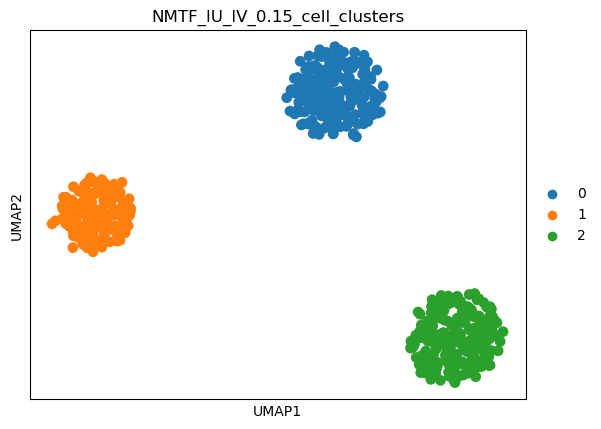

In [11]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep= "X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color = "NMTF_lU_lV_0.15_cell_clusters")

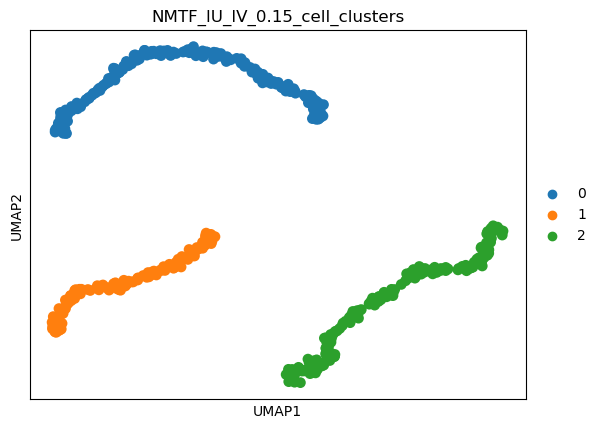

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep= "NMTF_lU_lV_0.15_cell_embedding", n_neighbors= 100)
sc.tl.umap(adata)
sc.pl.umap(adata, color = "NMTF_lU_lV_0.15_cell_clusters")

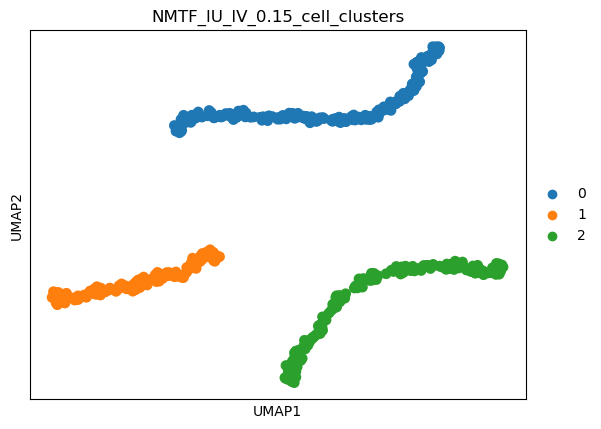

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep= "NMTF_lU_lV_0.15_P_embedding", n_neighbors= 100)
sc.tl.umap(adata)
sc.pl.umap(adata, color = "NMTF_lU_lV_0.15_cell_clusters")

/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


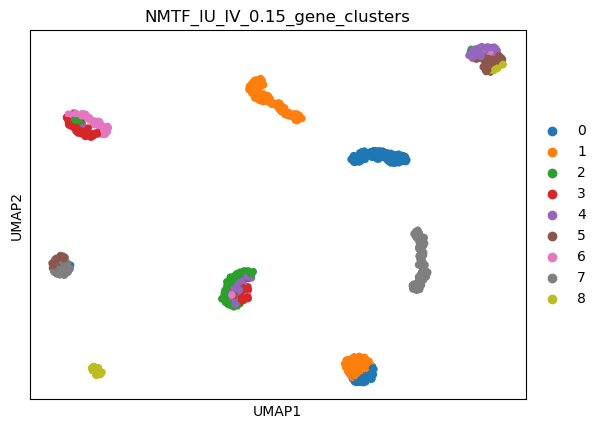

In [14]:
adata_genes = adata.T
sc.pp.pca(adata_genes)
sc.pp.neighbors(adata_genes, use_rep= "NMTF_lU_lV_0.15_Q_embedding", n_neighbors= 300)
sc.tl.umap(adata_genes)
sc.pl.umap(adata_genes, color = "NMTF_lU_lV_0.15_gene_clusters")

SCOTCH provides cluster visualization technique where the clusters are ordered, and each alternating cluster is assigned either a black or grey barcode. 

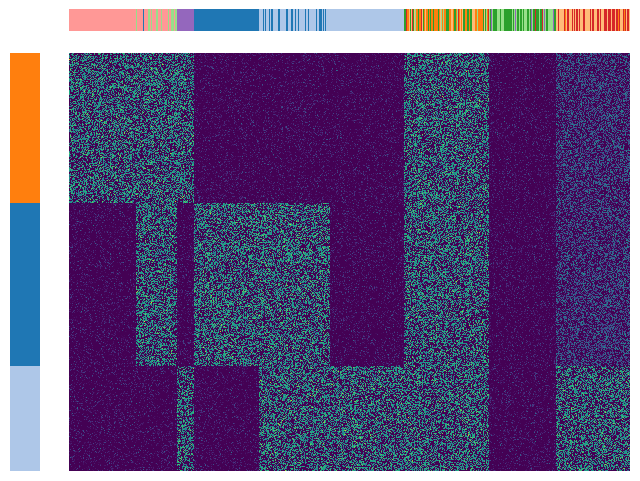

In [15]:
scotch.visualize_clusters()

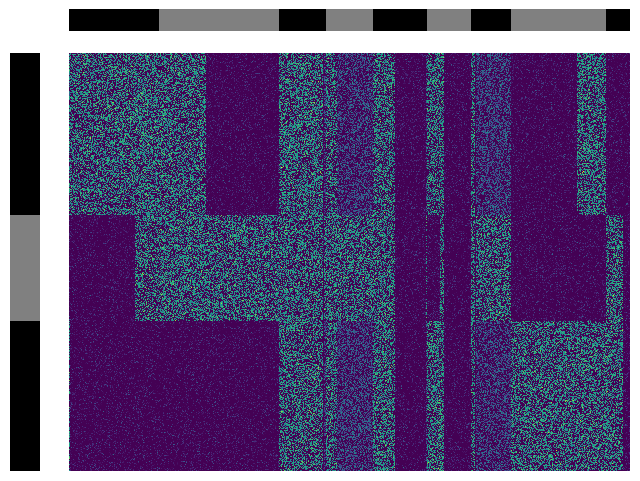

In [16]:
scotch.visualize_clusters_sorted()

The scotch update is susceptible to poor initialization which results in multiple factors representation similar contributions in V. This can result in some of the errors in clustering. One method to get around this is to utilize NMTF to generate a lower embedding, clustering the embedding, and using this as an initialization which accurately capture the relationship between factors. This is performed using the reclusterV function below.

In [17]:
scotch.recluster_V()
scotch.assign_cluster()

Iter: 1	Iter Time: 0.530	Total Time: 0.530	Objective: 6.883e+06	Relative Delta Objective: 5.415e-04	Reconstruction Error: 6.883e+06
Iter: 2	Iter Time: 0.335	Total Time: 0.865	Objective: 6.883e+06	Relative Delta Objective: -7.185e-05	Reconstruction Error: 6.883e+06
Iter: 3	Iter Time: 0.291	Total Time: 1.156	Objective: 6.884e+06	Relative Delta Objective: -1.306e-04	Reconstruction Error: 6.884e+06
Iter: 4	Iter Time: 0.318	Total Time: 1.474	Objective: 6.885e+06	Relative Delta Objective: -8.316e-05	Reconstruction Error: 6.885e+06
Iter: 5	Iter Time: 0.467	Total Time: 1.941	Objective: 6.885e+06	Relative Delta Objective: -3.166e-05	Reconstruction Error: 6.885e+06
Iter: 6	Iter Time: 0.673	Total Time: 2.614	Objective: 6.885e+06	Relative Delta Objective: -2.534e-05	Reconstruction Error: 6.885e+06
Iter: 7	Iter Time: 0.471	Total Time: 3.085	Objective: 6.885e+06	Relative Delta Objective: -2.694e-05	Reconstruction Error: 6.885e+06
Iter: 8	Iter Time: 0.433	Total Time: 3.518	Objective: 6.886e+06	Relati

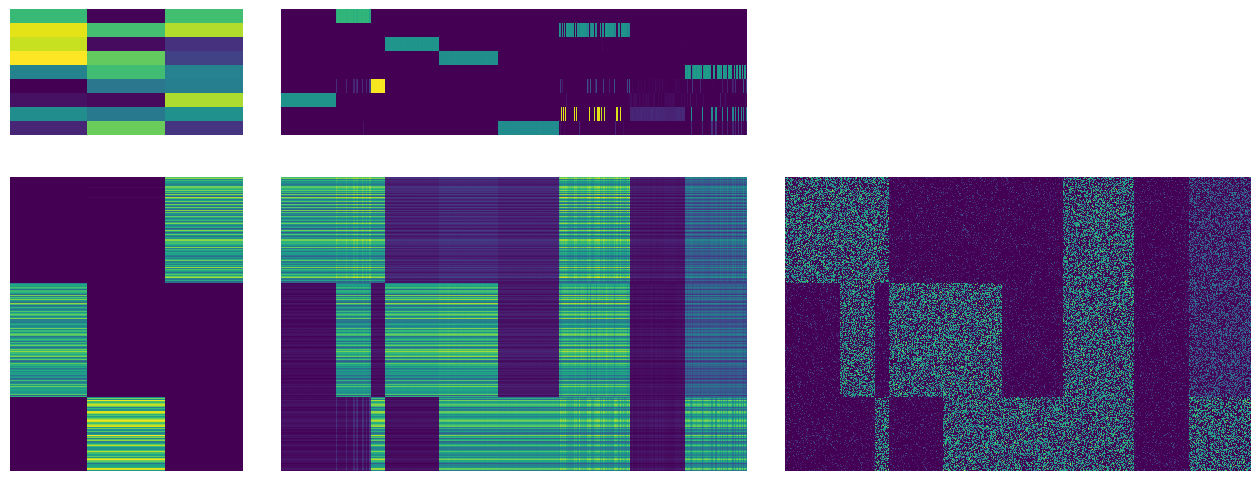

In [18]:
scotch.visualize_factors()

After running this function the elements of better capture different natural column clusters.   

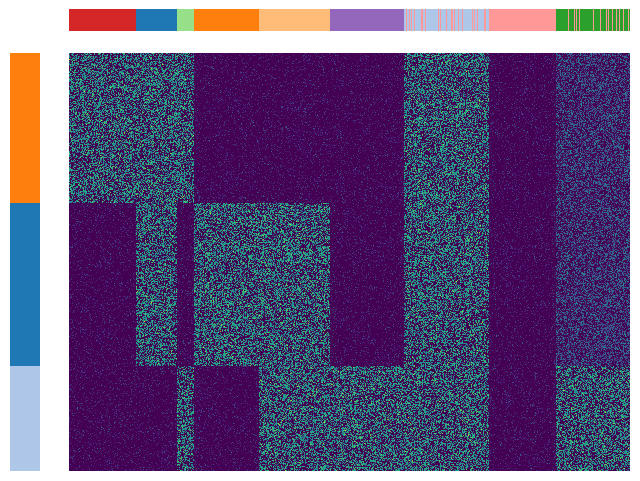

In [19]:
scotch.visualize_clusters()

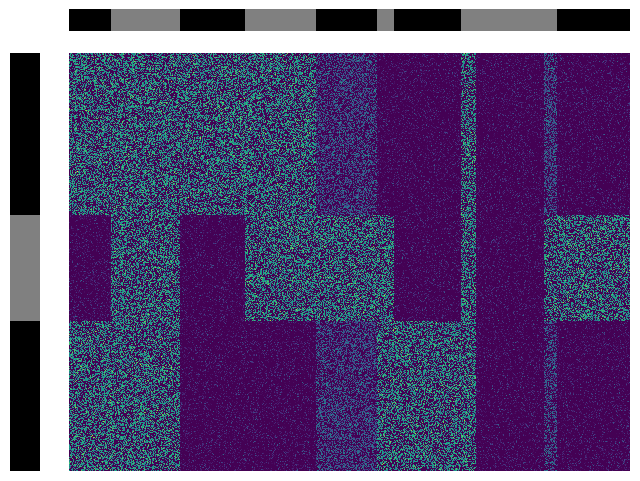

In [20]:
scotch.visualize_clusters_sorted()